# Imports 

In [23]:
!~/nbsetup ./
import numpy as np
from pyfuncs import plot
import pandas as pd
import xarray as xr
from glob import glob
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 2

Moved to directory ./.
Notebook is configured.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Zenith angle plot

In [25]:
np.arccos(.5)*180/np.pi

60.00000000000001

/home/ldavis/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in arccos
  # This is added back by InteractiveShellApp.init_path()


Figure setup complete.


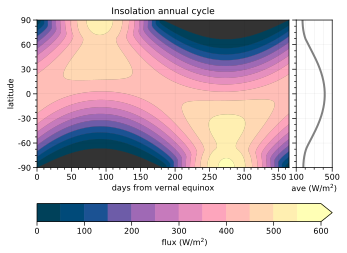

In [45]:
# see solar irradiance wikipdeia page; will plot in days relative to vernal equinox
# also did this in assignment 3 during ATS 606
# First get Qbars
# from pyfuncs import plot
plot.close() # close shit
S0 = 1367 # solar constant
ecc = 0.016704 # eccentricity
eps = 23.4398*np.pi/180 # obliquity
omega = 282.895*np.pi/180 # longitude of perihelion (relative to vernal equinox); this says occurs in boreal winter
def arccos(values): # wrapper
    sunset = np.arccos(values) # simple arccos
    sunset[values>1] = 0 # sunet hour angle relative to solar noon
    sunset[values<-1] = np.pi # will give zero insolation
    return sunset
delta = lambda theta: eps*np.sin(theta) # declination equals obliquity times sine (radians from vernal equinox)
Rratio = lambda theta: 1+ecc*np.cos(theta-omega)
h0 = lambda phi,theta: arccos(-np.tan(phi)*np.tan(delta(theta))) # just solve for cos(zen) = 0, get sunset hour; units are radians from solar noon, if 2pi rad equals diurnal cycle
Qbar = lambda phi,theta: (S0/np.pi)*Rratio(theta)**2*(h0(phi,theta)*np.sin(phi)*np.sin(delta(theta)) +
                     np.cos(phi)*np.cos(delta(theta))*np.sin(h0(phi,theta))) # phi is latitude in radians
thetas = np.linspace(0,2*np.pi,1000)
phis = np.linspace(-np.pi/2,np.pi/2,500)
Qbars = Qbar(phis[None,:],thetas[:,None]) # will be time of day by stuff
Qbars[Qbars==0] = np.nan
# Qbars[Qbars<0] = np.nan # no insolation yo
# Qbars[np.isnan(Qbars)] = np.nan # fix; sometimes get NaN values
# Plot stuff now
f, ax, p = plot.subplots(bottompanels=True, bspace=.5, bwidth=.25, aspect=2,
                         innerpanels=True, whichpanels='r')
# Contours
levels = plot.arange(0,600,50) # in W/m2
m = ax.contourf(thetas*365/(2*np.pi), phis*180/np.pi, Qbars, levels=levels, cmap='hclBlue_r', extend='max')
ax.format(xlabel='days from vernal equinox', ylabel='latitude', ylocator=30, title='Insolation annual cycle')
# Average or asymmetry
lw = 2
if 1:
    xlim = (100,500)
    Qbars[np.isnan(Qbars)] = 0 # back to zeros
    p.plot(Qbars.mean(axis=0), phis*180/np.pi, color='gray', lw=lw)
    p.format(xlim=xlim, xlocator=xlim, xlabel='ave ($W/m^2$)',
             ylim=(-90,90), ylocator=30, xgridminor=True, xtickminor=True)
else:
    xlim = (-6,6)
    Qmean = Qbars.mean(axis=0)
    nlat = phis.size
    Qhemimean = (Qmean[:nlat//2]+Qmean[-1:-nlat//2-1:-1])/2 # average
    Qhemimean = np.concatenate((Qhemimean,Qhemimean[::-1])) # paste back together
    Qassym = Qmean - Qhemimean
    p.plot(Qassym, phis*180/np.pi, color='gray', lw=lw)
    p.axvline(0, ls='--', color='k', lw=1, zorder=0)
    p.format(xlim=xlim, xlocator=(xlim[0],0,xlim[1]), xlabel='asymm ($W/m^2$)',
             ylim=(-90,90), ylocator=30)
# Panel
ax.patch.set_color('#333333') # looks gurd
f.bottompanel.colorbar(m, length=1, clabel='flux ($W/m^2$)', clocator=levels[::2])
f

#  Tests

In [2]:
%reload_ext autoreload
%autoreload 2

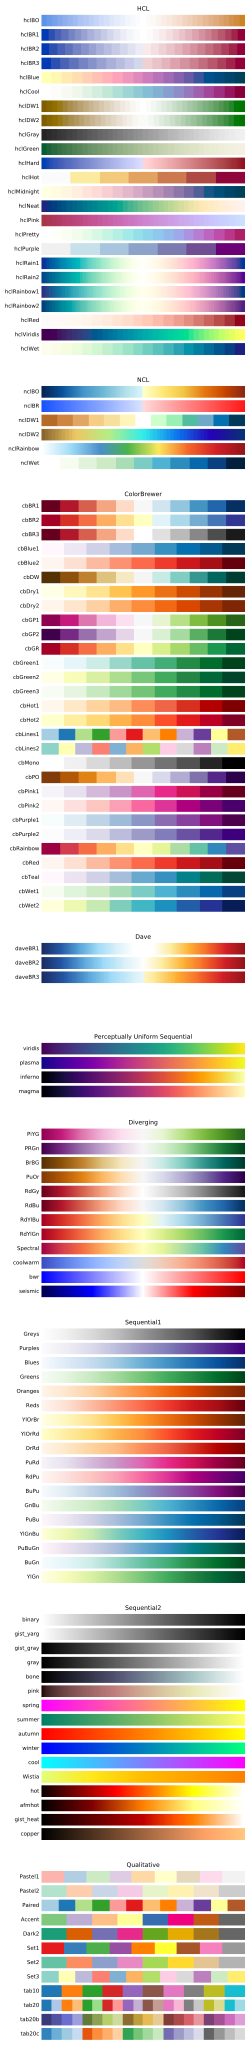

In [2]:
from pyfuncs import plot
f = plot.cmapshow()
f

In [17]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.register_cmap(cmap=mcolors.LinearSegmentedColormap.from_list('fart', [[0,0,0],[1,1,1]]))
plt.register_cmap(cmap=mcolors.LinearSegmentedColormap.from_list('hexfart', ['#aa0000', '#ffffff']))

Figure setup complete.


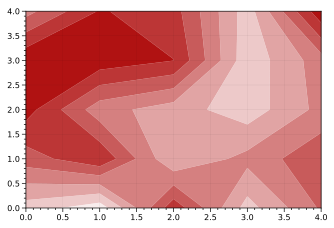

In [18]:
f, ax = plot.subplots()
n = 5
ax.contourf(np.arange(n), np.arange(n), np.random.rand(n,n), cmap='hexfart')
f

In [2]:
import scipy.optimize as opt

In [3]:
%matplotlib inline

In [7]:
DATADIR='./'

# Temperature height plots

In [18]:
dirs = glob('*/')
dirs = [d for d in dirs if 'src' not in d and 'results' not in d and 'co2' not in d]
dirs = ['tropical1_default']
datas = []
for d in dirs:
    files = [g for g in glob(f'{dirs[0]}/*') if 'spinup' in g and '.dat' in g]
    atms = files[-1]
    data = np.loadtxt(atms, skiprows=1)
    datas.append(data)

Figure setup complete.
tropical1_default/spinup00000.dat tropical1_default/spinup07200.dat
Figure setup complete.
tropical1_default/spinup00000.dat tropical1_default/spinup07200.dat


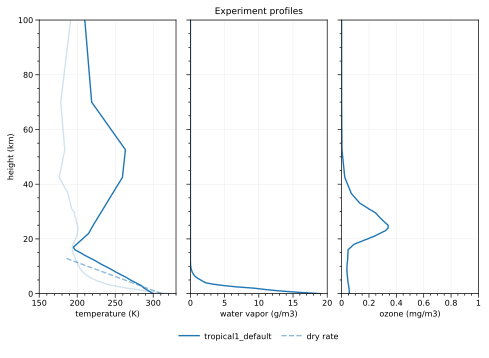

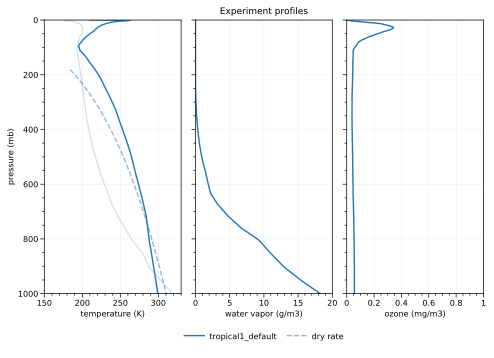

In [44]:
plot.close()
# Make plot
for coord in [0,1]:
    hs = []
    colors = ('C0','C1','C2','C3')
    dry = np.array([-(9.80665/1004)*z*1000 for z in datas[0][:,0]]) # dry lapse rate
    f, axs = plot.subplots(ncols=3, aspect=.5, width=7, bottompanel=True,
                          sharex=False, spanx=False, sharey=True)
    for d,direc in enumerate(dirs):
        files = sorted([g for g in sorted(glob(f'{direc}/*')) if 'spinup' in g and '.dat' in g])
        print(files[0], files[-1])
        data = np.loadtxt(files[0], skiprows=1)
        fdata = np.loadtxt(files[-1], skiprows=1)
        # print(data[:,2], fdata[:,2])
        p = data[:,coord] # p or z
        ylim = [(0,100), (1000,0)][coord]
        ylabel = ['height (km)', 'pressure (mb)'][coord]
        h1, = axs[0].plot(data[:,2], p, color=colors[d], label=dirs[d].strip('/')) # initial
        axs[0].plot(fdata[:,2], p, color=colors[d], alpha=.2, label=dirs[d].strip('/')) # final
        h2, = axs[0].plot([d if d>180 else np.nan for d in (data[0,2]+fdata[0,2])/2+dry], p,
                          color=colors[d], alpha=.5, label='dry rate', linestyle='--')
        axs[1].plot(data[:,3], p)
        axs[2].plot(data[:,4]*1e3, p)
        xlabels = ['temperature (K)', 'water vapor (g/m3)', 'ozone (mg/m3)']
        xlims = [(150,330), (0,20), (0,1)]
        for i,ax in enumerate(axs):
            ax.format(ylim=ylim, ylabel=ylabel, xlim=xlims[i],
                      xlabel=xlabels[i], suptitle='Experiment profiles')
        hs += [h1,h2]
    # Draw legend
    f.bottompanel.legend(hs, ncol=5)

In [55]:
times = sorted(g.split('spinup')[-1].split('.dat')[0] for g in glob(f'{dirs[0]}/*') if 'spinup' in g and '.dat' in g)
print(times)

['00000', '00024', '00048', '00072', '00096', '00120', '00144', '00168', '00192', '00216', '00240', '00264', '00288', '00312', '00336', '00360', '00384', '00408', '00432', '00456', '00480', '00504', '00528', '00552', '00576', '00600', '00624', '00648', '00672', '00696', '00720', '00744', '00768', '00792', '00816', '00840', '00864', '00888', '00912', '00936', '00960', '00984', '01008', '01032', '01056', '01080', '01104', '01128', '01152', '01176', '01200', '01224', '01248', '01272', '01296', '01320', '01344', '01368', '01392', '01416', '01440', '01464', '01488', '01512', '01536', '01560', '01584', '01608', '01632', '01656', '01680', '01704', '01728', '01752', '01776', '01800', '01824', '01848', '01872', '01896', '01920', '01944', '01968', '01992', '02016', '02040', '02064', '02088', '02112', '02136', '02160', '02184', '02208', '02232', '02256', '02280', '02304', '02328', '02352', '02376', '02400', '02424', '02448', '02472', '02496', '02520', '02544', '02568', '02592', '02616', '02640', 

In [6]:
ls

albedo.dat                    postprocess*       sbtest_5.txt
arcticW0_co2/                 README.pdf         sea.albedo.dat
arcticW0_co2_perturb.log      README-TESTS.pdf   src/
arcticW0_co2_spinup.log       results_orig/      test*
arcticW0_default/             rt.txt*            test_orig*
arcticW0_default_perturb.log  run*               tropical1_default/
arcticW0_default_spinup.log   sbdart*            tropicalW0_co2/
arcticW1_co2/                 sbdart.ipynb       tropicalW0_co2_perturb.log
arcticW1_co2_spinup.log       sbdart.tar.gz      tropicalW0_co2_spinup.log
arcticW1_default/             SBDART_WARNING.06  tropicalW0_default/
arcticW1_default_spinup.log   SBDART_WARNING.18  tropicalW0_default_perturb.log
atms.dat                      sbtest_1.txt       tropicalW0_default_spinup.log
batch*                        sbtest_21.txt      tropicalW1_co2/
disort.txt*                   sbtest_22.txt      tropicalW1_co2_spinup.log
empty                         sbtest_3.txt       trop

# Temperature time series

In [52]:
plot.close()
def make(expname='tropicalW0_co2', mode='perturb'):
    pressure = 1
    ylim = (-2,0) if mode=='perturb' else (-100,50)
    heights = [0,5,10,15,20, 25, 30, 35, 40, 45, 50, 70, 100] # use pressure or height
    # Load data
    lw = 2 # line width
    experiment = f'{DATADIR}/{expname}_{mode}.nc'
    data = xr.open_dataset(experiment, decode_times=False)
    # print(data['time'].values)
    # Plot data
    f, ax = plot.subplots(bottompanel=True, left=.5, bwidth=.2, bspace=.4) # for legend
    coord = 'p' if pressure else 'z'
    ylabel = 'pressure (mb)' if pressure else 'height (km)'
    title = expname.split('_'); title = f'{title[-1].title()} {title[0]} experiment'
    handles = []
    colors = plot.cmapcolors('tab20c', centered=True) # use native levels
    for color,height in zip(colors,heights):
        hid = np.argmin(np.abs(data['z'].values-height))
        temp = data['temp'].isel(level=hid)
        h, = ax.plot(data['time']/24, (temp-temp[0]), ls='-',
                     color=color, lw=lw, label=f'{height:d}km')
        handles += [h]
    ax.format(xlabel='time (days)', ylabel='temperature change (K)', title=title, yscale='linear',
              xscale='linear', ylim=ylim, xlim=(1,max(data['time'])/24))
    f.bottompanel.colorbar(colors[:len(heights)], values=heights, clabel='height (km)')

Figure setup complete.
Figure setup complete.
Figure setup complete.
Figure setup complete.
Figure setup complete.
Figure setup complete.
Figure setup complete.
Figure setup complete.


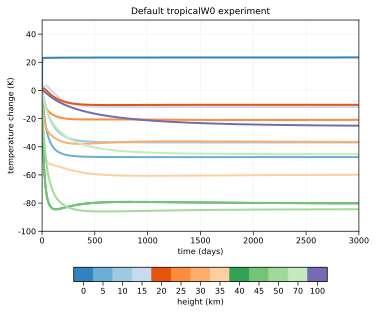

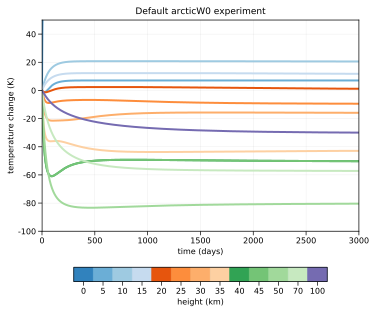

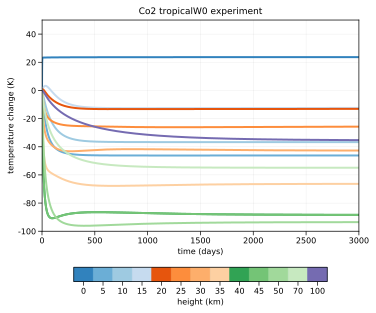

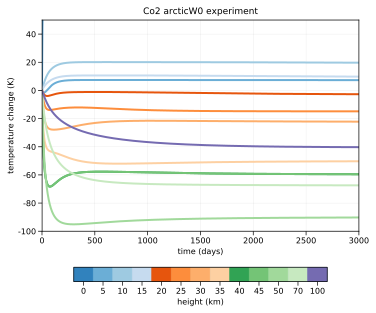

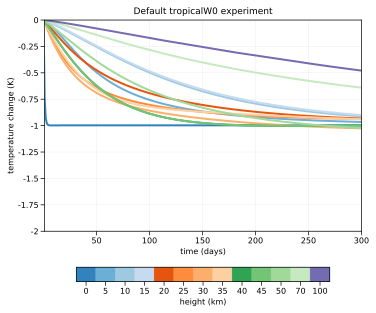

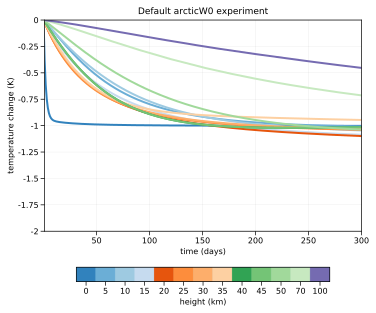

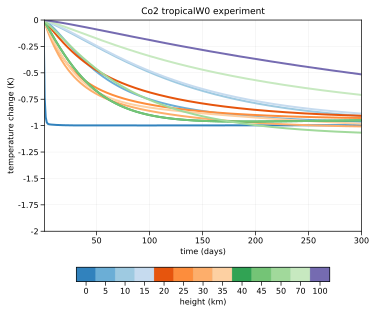

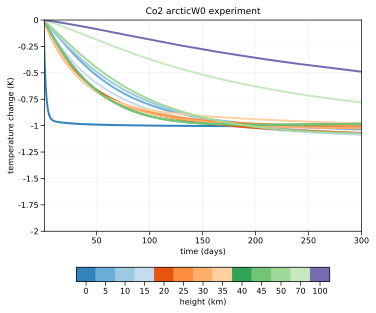

In [58]:
for mode in ('spinup','perturb'):
    for cmode in ('default','co2'):
        for amode in ('tropical','arctic'):
            make(f'{amode}W0_{cmode}', mode)

# Timescales

In [9]:
plot.close()
def timescales(expnames, title='Radiative timescales in different atmospheres',
        colors=None, alphas=None, lws=None, smooth=True, # use smooth to smooth out discontinuities
        pressure=1, xscale='log', xlim=(0,500)):
    # Plot data
    hs = []
    fig, ax = plot.subplots(bottompanel=True, left=.6, width=3, right=.3,
                            bwidth=.5, bspace=0, aspect=.5) # for legend
    for i,expname in enumerate(expnames):
        color = None if colors is None else colors[i]
        lw = None if lws is None else lws[i]
        alpha = None if alphas is None else alphas[i]
        zorder = len(expnames)-i
        label = expname.split('W')[0]
        # if 'arctic' in label: label = label.title() # Arctic is proper noun
        label = label.title()
        if 'co2' in expname: label = f'$2\\times CO_2$ {label}'
        experiment = f'{DATADIR}/{expname}_perturb.nc'
        data = xr.open_dataset(experiment, decode_times=False)
        timescales = []
        for l in range(data['z'].size):
            temp, time = data['temp'].isel(level=l).values, data['time'].values/24
            f = lambda t,tau: (temp[0] - 1) + np.exp(-t/tau) # curve fit
            timescale, _ = opt.curve_fit(f, time, temp, 20) # try 20 days by default
            timescales += [timescale[0]]
        timescales = np.array(timescales) # put into array
        if smooth: timescales = np.concatenate((timescales[:2].sum(keepdims=True)/2,
            (0.5*timescales[2:]+timescales[1:-1]+0.5*timescales[:-2])/2,
            timescales[-2:].sum(keepdims=True)/2)) # combine
        if not pressure:
            heights = data['z'].values
            ysettings = {'ylabel':'height (km)', 'ylim':(0,100)}
        else:
            heights = data['p'].values
            ysettings = {'ylabel':'pressure (hPa)', 'ylim':(1015,0)}
        h, = ax.plot(timescales, heights, ls='-', label=label, zorder=zorder,
                    lw=lw, alpha=alpha, color=color)
        hs.append(h)
    ax.format(xlabel='time (days)', xlim=xlim, xscale=xscale, **ysettings,
              title=title)
    fig.bottompanel.legend(hs, ncol=2)
    return fig, ax

Figure setup complete.
Extra border space: left 0.14, bottom -0.06, right 0.19, top 0.12.
Try these params to avoid adjustment: left 0.46, bottom 0.56, right 0.11, top 0.18.
Saving to timescales-p0-s0.pdf.
Figure setup complete.
Extra border space: left 0.07, bottom -0.06, right 0.24, top 0.12.
Try these params to avoid adjustment: left 0.53, bottom 0.56, right 0.06, top 0.18.
Saving to timescales-p1-s0.pdf.
Figure setup complete.
Extra border space: left 0.14, bottom -0.06, right 0.19, top 0.12.
Try these params to avoid adjustment: left 0.46, bottom 0.56, right 0.11, top 0.18.
Saving to timescales-p0-s1.pdf.
Figure setup complete.
Extra border space: left 0.07, bottom -0.06, right 0.24, top 0.12.
Try these params to avoid adjustment: left 0.53, bottom 0.56, right 0.06, top 0.18.
Saving to timescales-p1-s1.pdf.


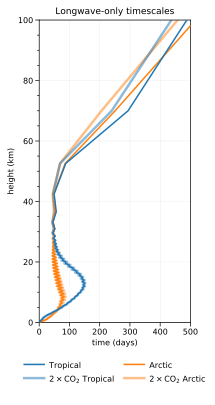

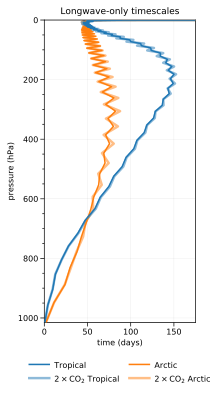

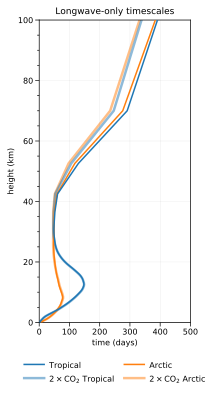

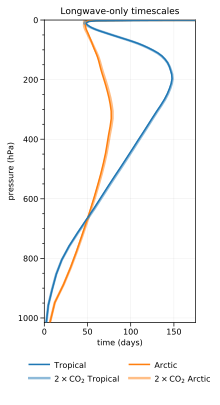

In [11]:
expnames = ['tropicalW0_default', 'arcticW0_default', 'tropicalW0_co2', 'arcticW0_co2']
for smooth in (0,1):
    for pressure in (0,1):
        xlim = (0,175) if pressure else (0,500)
        fig, ax = timescales(expnames, pressure=pressure, xscale='linear', xlim=xlim, smooth=smooth,
            colors=('C0','C1','C0','C1'), alphas=(1,1,.5,.5), lws=(1.5,1.5,2.5,2.5),
            title='Longwave-only timescales')
        fig.save(f'timescales-p{pressure:d}-s{smooth:d}.pdf')

# Profiles

In [182]:
ls -d */

arcticW0_co2//      results_orig//       tropicalW0_default//
arcticW0_default//  src//                tropicalW1_co2//
arcticW1_co2//      tropical1_default//  tropicalW1_default//
arcticW1_default//  tropicalW0_co2//


In [ ]:
!cat tropicalW0_default/atms.dat

Figure setup complete.
Extra border space: left 0.21, bottom -0.06, right 0.04, top 0.12.
Try these params to avoid adjustment: left 0.39, bottom 0.46, right 0.06, top 0.18.
Saving to profile-p0.pdf.
Figure setup complete.
Extra border space: left 0.07, bottom -0.06, right 0.04, top 0.12.
Try these params to avoid adjustment: left 0.53, bottom 0.46, right 0.06, top 0.18.
Saving to profile-p1.pdf.


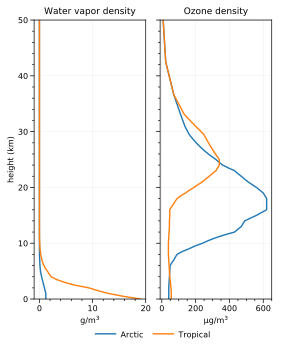

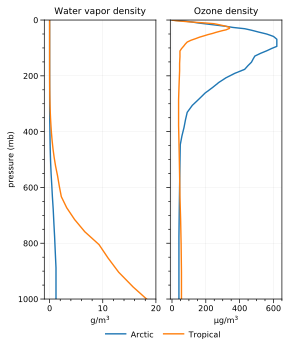

In [35]:
pressure = 0
for pressure in [0,1]:
    hs = ()
    f, axs = plot.subplots(ncols=2, bottompanel=True, spanx=False, left=.6,
                           width=4, bottom=.4, bwidth=.3, bspace=0, aspect=.4)
    expnames = ['arcticW0_default', 'tropicalW0_default']
    # Plot
    for expname in expnames:
        data = np.loadtxt(f'{expname}/atms.dat', skiprows=1)
        z = data[:,1] if pressure else data[:,0] # use dat yo
        h, = axs[0].plot(data[:,-2], z, label=expname.split('W')[0].title()) # water vapor
        axs[1].plot(data[:,-1]*1e6, z) # ozone
        hs += h,
    # Format
    ysettings = {'ylabel':'pressure (mb)', 'ylim':(1000,0)} if pressure \
        else {'ylabel':'height (km)', 'ylim':(0,50)}
    axs[0].format(xlabel='$g/m^3$', title='Water vapor density', xlim=(-1,20), **ysettings)
    axs[1].format(xlabel='${\mu}g/m^3$', title='Ozone density', xlim=(-10,650))
    f.bottompanel.legend(hs, ncol=5)
    f.save(f'profile-p{pressure:d}.pdf')

# Heating

Figure setup complete.
Extra border space: left 0.14, bottom -0.06, right 0.24, top 0.12.
Try these params to avoid adjustment: left 0.46, bottom 0.46, right 0.06, top 0.18.
Saving to heating-p0-s0.pdf.
Figure setup complete.
Extra border space: left 0.07, bottom -0.06, right 0.24, top 0.12.
Try these params to avoid adjustment: left 0.53, bottom 0.46, right 0.06, top 0.18.
Saving to heating-p1-s0.pdf.
Figure setup complete.
Extra border space: left 0.14, bottom -0.06, right 0.24, top 0.12.
Try these params to avoid adjustment: left 0.46, bottom 0.46, right 0.06, top 0.18.
Saving to heating-p0-s1.pdf.
Figure setup complete.
Extra border space: left 0.07, bottom -0.06, right 0.24, top 0.12.
Try these params to avoid adjustment: left 0.53, bottom 0.46, right 0.06, top 0.18.
Saving to heating-p1-s1.pdf.


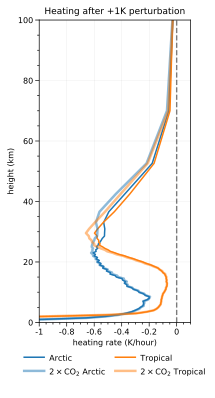

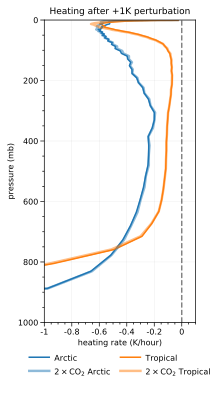

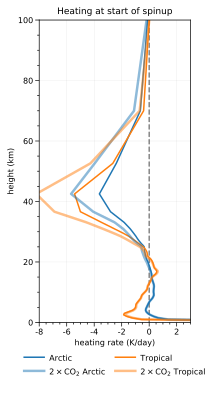

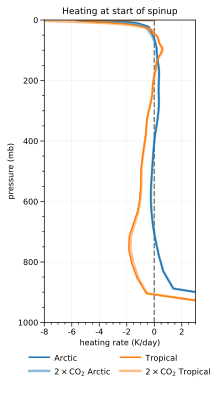

In [70]:
pressure = 0
for spinup in [0,1]:
    ftype = 'spinup' if spinup else 'perturb'
    units = 'day' if spinup else 'hour'
    scale = 1 if spinup else 24 # to hours
    title = 'Heating at start of spinup' if spinup else 'Heating after +1K perturbation'
    for pressure in [0,1]:
        hs = ()
        f, ax = plot.subplots(bottompanel=True, spanx=False, left=.6, right=.3,
                               width=3, bottom=.4, bwidth=.5, bspace=0, aspect=.5)
        expnames = ['arcticW0_default', 'tropicalW0_default']
        # Plot
        for co2 in (0,1):
            for i,expname in enumerate(expnames):
                label = expname.split('W')[0]
                expname = expname.replace('default','co2') if co2 else expname
                label = label.title()
                lw = 2.5 if co2 else 1.5
                alpha = .5 if co2 else 1
                color = ('C0','C1')[i]
                label = f'$2\\times CO_2$ {label}' if co2 else label
                data = np.loadtxt(f'{expname}/{ftype}00000.txt', skiprows=1)
                z = data[:,1] if pressure else data[:,0] # use dat yo
                h, = ax.plot(data[:,-2]*scale, z, color=color, label=label, lw=lw, alpha=alpha) # water vapor
                hs += h,
        # Format
        xlim = (-8,3) if spinup else (-1,.1)
        ysettings = {'ylabel':'pressure (mb)', 'ylim':(1000,0)} if pressure \
            else {'ylabel':'height (km)', 'ylim':(0,100)}
        ax.format(xlabel=f'heating rate (K/{units})', xlim=xlim, title=title, **ysettings)
        f.bottompanel.legend(hs, ncol=2)
        ax.axvline(x=0, color='gray', zorder=1, ls='--')
        f.save(f'heating-p{pressure:d}-s{spinup:d}.pdf', tight=False)

In [ ]:
ls tropicalW0_default/perturb*